In [1]:
from periodictable import elements
from pymatgen import MPRester
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

%matplotlib inline
cm = plt.cm.get_cmap('Set2', 8)

# Scrape data from MP API

In this section, we create a dataframe containing the formation energies and chemistries, in elemental mole percent, of all compounds in the Materials Project database. We utilize the pymatgen module to scrape the Materials Project.

In [390]:
mpr = MPRester("t3rgWSpsJcHohXKQ") # Get API key

In [2]:
# Create a list of all elements in the periodic table
element_list = []
for el in elements:
    element_list.append(str(el))
del(element_list[0]) # The first entry is a proton, so we delete this entry

In [392]:
# Collects all compounds in the database and stores the composition and formation energy.
unformatted_data = mpr.query({"elements": {"$in":element_list}}, ["reduced_cell_formula", "formation_energy_per_atom"])

In [396]:
unformatted_data[0] # Example of first entry in unformatted_data

{'formation_energy_per_atom': 0.0, 'reduced_cell_formula': {'Ac': 1.0}}

In [397]:
''' Function to change the data structure slightly so that each entry looks like: 
    {'formation_energy', 'Element 1 at%', 'Element 2 at%', ... , 'Element n at%'}''' 

def convert_to_dict(entry):
    data = {}
    data['formation_energy_per_atom'] = entry['formation_energy_per_atom']
    for key, value in entry['reduced_cell_formula'].items():
        data[key] = value
    return data

In [398]:
formatted_data = []
for entry in unformatted_data:
    formatted_data.append(convert_to_dict(entry))

In [399]:
formatted_data[0] # Example of first entry in formatted_data

{'Ac': 1.0, 'formation_energy_per_atom': 0.0}

In [401]:
df = pd.DataFrame(formatted_data) # Put data into dataframe
df.fillna(value=0, inplace=True) # Change na values to 0

In [67]:
df.head()

,Ac,Ag,Al,Ar,As,Au,B,Ba,Be,Bi,...,Tm,U,V,W,Xe,Y,Yb,Zn,Zr,formation_energy_per_atom
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012598
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.107647
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.275183
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.059763


In [402]:
X = df.iloc[:,0:89] # Create matrix X that contains our features
y = df.iloc[:,89:90] # Create vector y that has our target values

In [403]:
''' Function to normalize the chemistry of every entry in our dataframe. '''

def normalize_chemistry(row):
    total = row.sum()
    return row / total

In [404]:
X = X.apply(normalize_chemistry, axis=1)
X.head()

,Ac,Ag,Al,Ar,As,Au,B,Ba,Be,Bi,...,Tl,Tm,U,V,W,Xe,Y,Yb,Zn,Zr
0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Save data for future offline use
X.to_csv('chemistry_data.csv')
y.to_csv('formation_energy_data.csv')

#  Visualize data

In this section, we visualize the chemical makeup of compounds in our dataset by creating a heatmap that shows the frequencies of elements and pairs of elements in the compounds in our dataset.

In [8]:
# Create dataframe where each index is an element in the periodic table and each columns is also
# an element on the periodic table. The value of a particular entry in the dataframe is the number
# of times the pair of elements is encountered in our data. We begin by setting 0 to every entry. 
df = pd.DataFrame(np.zeros((len(element_list),len(element_list))), index=element_list, columns=element_list) 

# For every compound we've scraped, we first find which elements are in the compound
for compound in range(len(X)):
    element_indices_in_compound = X.iloc[compound].nonzero()
    elements_in_compound = [ element for index in element_indices_in_compound for element in X.columns[index] ]
    
    # We now find every pair of elements in the compound and add 1 to the entries corresponding to those pairs.
    # For example, consider LiCu2O2. The following entries would be amended by 1: Li-Li, Li-Cu, Cu-Li, Li-O, 
    # O-Li, Cu-Cu, Cu-O, O-Cu, and O-O
    for i in range(len(elements_in_compound)):
        for j in range(i,len(elements_in_compound)):
            if i==j:
                df.loc[elements_in_compound[i], elements_in_compound[j]] += 1
            else:
                df.loc[elements_in_compound[i], elements_in_compound[j]] += 1
                df.loc[elements_in_compound[j], elements_in_compound[i]] += 1

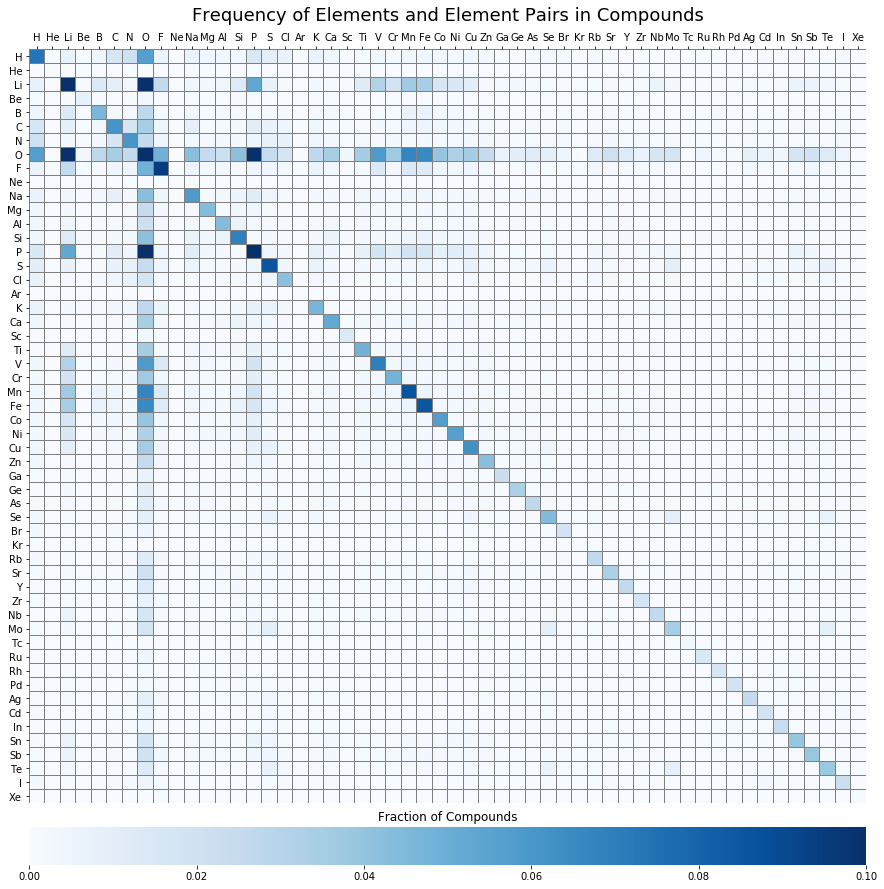

In [101]:
# Plot heatmap, where darkest blue represents 10% of compounds in our database. The trace shows the frequency 
# of elements in the database and the off-diagonal elements show the frequency of pairs of elements. Only first
# five rows of periodic table are shown.
grid_kws = {"height_ratios": (0.995, .05), "hspace": 0.06} # Format subplot sizes and spacing
fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(15,15))
ax = (sns.heatmap(df.iloc[0:54, 0:54].divide(X.shape[0]), ax=ax, cbar_ax = cbar_ax,
                  vmax=0.1, cmap="Blues", linewidth=0.005, linecolor='grey',
                  cbar_kws={"orientation": "horizontal"}))
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top') # x axis on top
ax.set_title('Frequency of Elements and Element Pairs in Compounds', y=1.03, size=18)
cbar_ax.set_title('Fraction of Compounds', y=1.02)

In [ ]:
# Save data for future offline use
df.to_csv('compound_count.csv')

# Fit linear regression to data

In this section, we use linear regression to generate an algorithm that predicts the formation energy of a compound only using only its chemical formula.

In [3]:
# Import data
X = pd.read_csv('chemistry_data.csv', index_col=0)
y = pd.read_csv('formation_energy_data.csv', index_col=0)

In [4]:
# Divide data into training (60%), cv (20%), and test sets (20%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.4, random_state=15)
X_cv, X_test, y_cv, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state=24)

In [48]:
clf = (Ridge(random_state=33, alpha=1, fit_intercept=True, normalize=False, copy_X=True, max_iter=100)
       .fit(X_train, y_train)) # Fit linear regression to training set

In [105]:
y_pred = clf.predict(X_cv) # Use regression to predict cv formation energies

In [5]:
''' Function that returns RMS error of predictions. '''

def get_rms_error(y_actual, y_pred):
    rms_error = math.sqrt(((np.array(y_actual) - y_pred) ** 2).sum() / len(y_cv))
    return rms_error

In [107]:
rms_error = get_rms_error(y_cv, y_pred)
print('The RMS error for the CV data set is: ' + str(rms_error) + ' eV/atom.')

The RMS error for the CV data set is: 0.5020696427464963 eV/atom.


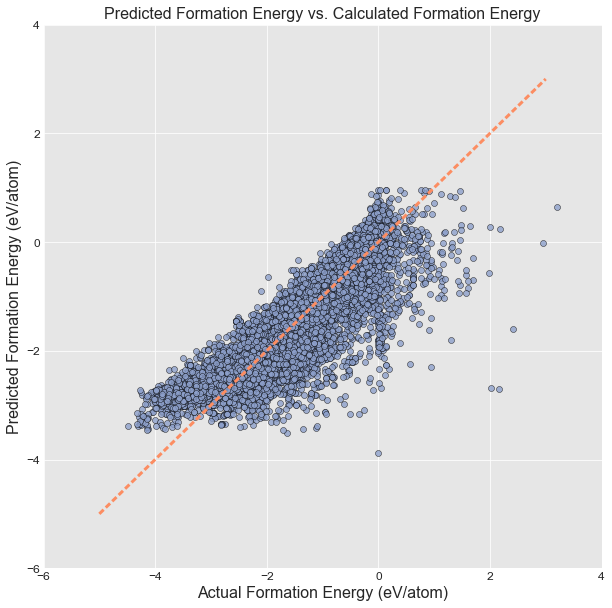

In [110]:
# Plot predicted formation energy versus actual formation energy. The orange line shows a perfect fit

linear = np.linspace(-5, 3, num=1000) # Linear array for plot. Perfect algorithm would fall on this line.

fig = plt.figure(figsize=(10,10))
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) # style adjustment
ax = sns.regplot(np.array(y_cv), np.array(y_pred), fit_reg=False, color=cm.colors[2], scatter_kws={'linewidths':0.5, 'edgecolors':'k'})
ax.tick_params(labelsize=12)
ax.set_xlabel('Actual Formation Energy (eV/atom)', fontsize=16)
ax.set_ylabel('Predicted Formation Energy (eV/atom)', fontsize=16)
plt.plot(linear, linear, c=cm.colors[1], linewidth=3, linestyle='--', dashes=(2,1)) # lin
plt.xlim(-6,4)
plt.ylim(-6,4)
plt.title('Predicted Formation Energy vs. Calculated Formation Energy', size=16)

#  Fit neural network (1 hidden layer, 5 neurons)

In this section, we instead fit a neural network, which allows us to make non-linear predictions.

In [129]:
# Fit neural network with single hidden layer with 5 neurons
clf = (MLPRegressor(solver='lbfgs', alpha=0, hidden_layer_sizes=(5), 
                    random_state=1, max_iter=1000).fit(X_train, y_train.values.ravel()))

In [20]:
y_pred = clf.predict(X_cv) # Use neural net to predict cv set values
y_pred.resize(len(y_pred),1) # Reshape data into vector

In [21]:
rms_error = get_rms_error(y_cv, y_pred)
print('The RMS error for 1x5 neural network on the CV data set is: ' + str(rms_error) + ' eV/atom.')

The RMS error for 1x5 neural network on the CV data set is: 0.24030933565078896 eV/atom.


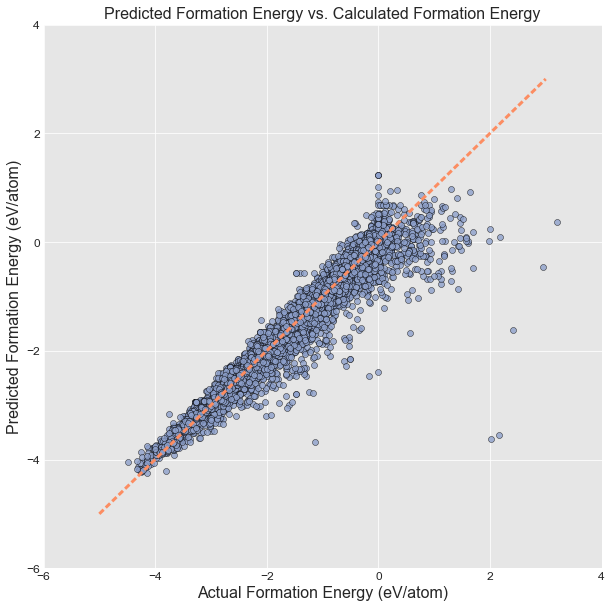

In [143]:
# Plot predicted formation energy versus actual formation energy. The orange line shows a perfect fit
fig = plt.figure(figsize=(10,10))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
ax = sns.regplot(np.array(y_cv.values), np.array(y_pred), fit_reg=False, color=cm.colors[2], scatter_kws={'linewidths':0.5, 'edgecolors':'k'})
ax.tick_params(labelsize=12)
ax.set_xlabel('Actual Formation Energy (eV/atom)', fontsize=16)
ax.set_ylabel('Predicted Formation Energy (eV/atom)', fontsize=16)
plt.plot(linear, linear, c=cm.colors[1], linewidth=3, linestyle='--', dashes=(2,1))
plt.xlim(-6,4)
plt.ylim(-6,4)
plt.title('Predicted Formation Energy vs. Calculated Formation Energy', size=16)

#  Fit other networks (5 HL x 5 neurons, 1 HL x 10 neurons)

In this section, we determine if having more hidden layers or more units in each hidden layer improves the RMS error. It does not.

In [6]:
# Fit neural network with five hidden layers and five neurons per hidden layer
clf = (MLPRegressor(solver='lbfgs', alpha=0, hidden_layer_sizes=(5, 5, 5, 5, 5), 
                    random_state=1, max_iter=1000).fit(X_train, y_train.values.ravel()))

In [7]:
y_pred = clf.predict(X_cv) # Use neural net to predict cv set values
y_pred.resize(len(y_pred),1) # Reshape data into vector

In [8]:
rms_error = get_rms_error(y_cv, y_pred)
print('The RMS error for the 5x5 neural net on the CV data set is: ' + str(rms_error) + ' eV/atom.')

The RMS error for the 5x5 neural net on the CV data set is: 0.4630276564759568 eV/atom.


In [15]:
# Fit neural network with one hidden layer but 10 nuerons
clf = (MLPRegressor(solver='lbfgs', alpha=0, hidden_layer_sizes=(10), 
                    random_state=1, max_iter=1000).fit(X_train, y_train.values.ravel()))

In [16]:
y_pred = clf.predict(X_cv) # Use neural net to predict cv set values
y_pred.resize(len(y_pred),1) # Reshape data into vector

In [17]:
rms_error = get_rms_error(y_cv, y_pred)
print('The RMS error for 1x10 neural net on the CV data set is: ' + str(rms_error) + ' eV/atom.')

The RMS error for 1x10 neural net on the CV data set is: 0.25920210045243647 eV/atom.


#  Neural network test set error

In [132]:
# Calculate RMS error on test set.

y_pred = clf.predict(X_test) # Use neural net to predict cv set values
y_pred.resize(len(y_pred),1) # Reshape data into vector

rms_error = get_rms_error(y_test, y_pred)
print('The RMS error for 1x5 neural network on the test data set is: ' + str(rms_error) + ' eV/atom.')

The RMS error for 1x5 neural network on the test data set is: 0.22502171673240376 eV/atom.


#  Overfitting or underfitting?

In this section, we plot the learning curve of the (1x5) neural network in order to figure out whether or not we are underfitting or overfitting our data. We are underfitting.

In [6]:
''' Function that computes the cost of a neural networks predictions. '''

def cost_function(X, y, alpha):
    reg_cost = 0
    for array in clf.coefs_:
        reg_cost += (array**2).sum()
    reg_cost *= alpha / 2 
    reg_cost += ((clf.predict(X) - y.values.ravel())**2).sum() / 2
    reg_cost /= X.shape[0]
    return reg_cost

In [7]:
# Compute J_train and J_cv

J_train = [] # Training cost
J_cv = [] # CV cost
training_set_size = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for size in training_set_size:
    X_lc, X_rest, y_lc, y_rest = train_test_split(X_train, y_train, test_size = 1-size, random_state=15) #Split dataset
    clf = (MLPRegressor(solver='lbfgs', alpha=0, hidden_layer_sizes=(5), 
                        random_state=1).fit(X_lc, y_lc.values.ravel())) # Fit neural network
    J_train.append(cost_function(X_lc, y_lc, 0)) # Append training cost to J_train
    J_cv.append(cost_function(X_cv, y_cv, 0)) # Append cv cost to J_cv

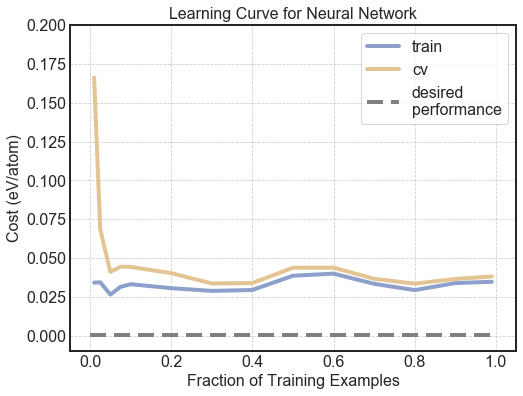

In [10]:
# Desired performance is a RMS of 0.02 eV/atom. The equivalent cost is RMS^2 / 2.
desired_performance = (0.02)**2 / 2
dp_x = [0, 1]
dp_y = [desired_performance, desired_performance]

# Plot learning curve.
sns.set_style("white", {"axes.linewidth": 2.0, "axes.grid": True, "grid.color": "0.8", "legend.frameon": True, "grid.linestyle": u'--'})
fig = plt.figure(figsize=(8,6))
plt.plot(training_set_size, J_train, label='train', color=cm.colors[2], linewidth=4)
plt.plot(training_set_size, J_cv, label='cv', color=cm.colors[6], linewidth=4)
plt.plot(dp_x, dp_y, color = 'gray', linewidth = 4, linestyle = '--', dashes=(4,2), label='desired\nperformance')
plt.title('Learning Curve for Neural Network', size=16)
plt.xlabel('Fraction of Training Examples', size=16)
plt.ylabel('Cost (eV/atom)', size=16)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.01,0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(prop={'size': 16})

The learning curve suggests that our algorithm is likely underfit, which is not surprising given the relatively large number of training examples (~70,000) relative to the number of features (~100).

#  Error visualization

In this section, we again use a heatmap to visualize the errors in our dataset. The heat map shows that the errors are distributed relatively randomly throughout the dataset. For instance, it does not seem like the error for compounds with higher atomic number elements is generally higher than those with lower number. More work should be done to understand the distribution of errors.

In [121]:
# Heatmap of RMS prediction errors. The RMS error of all compounds containing a particular pair of elements 
# is assigned to each entry. Consider the entry for Li-O. The algorithm finds the errors for all compounds 
# containing Li and O. To obtain the RMS error, (1) the squares of the individual errors are added together, 
# (2) the sum is divided by the number of compounds containing Li and O, and (3) the square root is taken.

# matrix containing RMS errors
df_error = pd.DataFrame(np.zeros((len(element_list),len(element_list))), index=element_list, columns=element_list)
# matrix containing number of times pairs of elements are found in compounds
count_matrix = pd.DataFrame(np.zeros((len(element_list),len(element_list))), index=element_list, columns=element_list)

for compound in range(len(X_cv)):
    element_indices_in_compound = X.iloc[compound].nonzero()
    elements_in_compound = [ element for index in element_indices_in_compound for element in X.columns[index] ]
    error = (y_cv.iloc[compound, 0] - y_pred[compound, 0])**2 # square error
    
    for i in range(len(elements_in_compound)):
        for j in range(i,len(elements_in_compound)):
            if i==j:
                df_error.loc[elements_in_compound[i], elements_in_compound[j]] += error # add error to df_error
                count_matrix.loc[elements_in_compound[i], elements_in_compound[j]] += 1 # add count to count_matrix
            else:
                df_error.loc[elements_in_compound[i], elements_in_compound[j]] += error
                df_error.loc[elements_in_compound[j], elements_in_compound[i]] += error
                count_matrix.loc[elements_in_compound[i], elements_in_compound[j]] += 1
                count_matrix.loc[elements_in_compound[j], elements_in_compound[i]] += 1

df_error = df_error.divide(count_matrix)
df_error = np.power(df_error, 0.5)

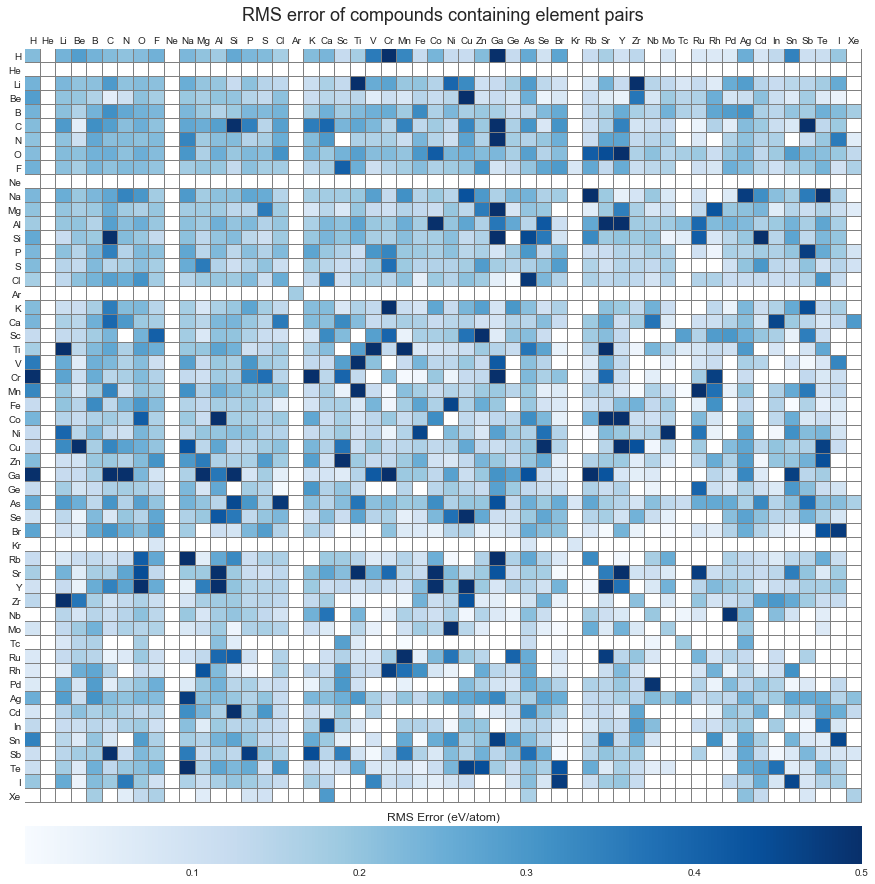

In [124]:
# Plot heatmap, where darkest blue represents 10% of compounds in our database. The trace shows the frequency 
# of elements in the database and the off-diagonal elements show the frequency of pairs of elements. Only first
# five rows of periodic table are shown.
grid_kws = {"height_ratios": (0.995, .05), "hspace": 0.06}
fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(15,15))
ax = (sns.heatmap(df_error.iloc[0:54, 0:54], ax=ax, cbar_ax = cbar_ax,
                  vmax=0.5, cmap="Blues", linewidth=0.005, linecolor='grey',
                  cbar_kws={"orientation": "horizontal"}))
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title('RMS error of compounds containing element pairs', y=1.03, size=18)
cbar_ax.set_title('RMS Error (eV/atom)', y=1.02)